In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def positional_encoding(x, num_frequencies=6, incl_input=True):

    results = []
    if incl_input:
        results.append(x)
    # encode input tensor and append the encoded tensor to the list of results.
    freq = torch.pow(2,torch.arange(num_frequencies)).to(device)
    sin_list = torch.sin(torch.pi*freq*x.reshape((-1,1))).to(device)
    cos_list  = torch.cos(torch.pi*freq*x.reshape((-1,1))).to(device)
    results.append(sin_list.reshape((x.shape[0],-1)))
    results.append(cos_list.reshape((x.shape[0],-1)))
    return torch.cat(results, dim=-1)


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


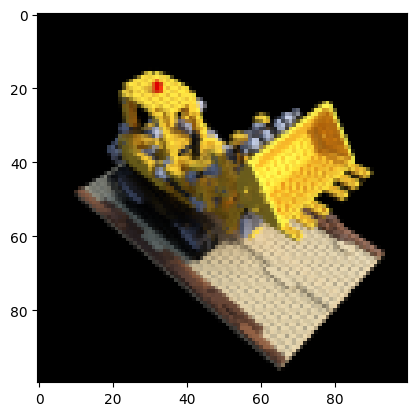

In [4]:
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)

# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

In [5]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):

    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
    ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder

    coords = torch.stack(torch.meshgrid(torch.arange(height), torch.arange(width), indexing='xy'), -1).reshape((-1,2))
    coords = torch.concat((coords, torch.ones(coords.shape[0],1)), -1).to(device)
    # print(w_R_c.dtype, intrinsics.dtype, coords.dtype, w_T_c.dtype)
    rays = w_R_c @ torch.linalg.inv(intrinsics) @ coords.T
    # print(rays[:2,...])
    # print(rays.shape)
    rays = rays/torch.norm(rays, dim=0)
    rays_directions = rays.T.reshape((height,width,3))
    rays_origins = torch.broadcast_to(w_T_c.T, ((height, width,3)))
    # print(rays_directions.shape, rays_directions[0,:2,:])
    # print(rays_origins.shape, rays_origins[0,:2,:])

    return rays_origins, rays_directions

In [ ]:
def plot_all_poses(poses):


    poses = torch.Tensor(poses).to(device)
    # print(poses.dtype)
    w_R_c = poses[:,:3,:3]
    w_T_c = poses[:,:3,3]
    origins = torch.zeros((poses.shape[0],height, width, 3))
    directions = torch.zeros((poses.shape[0],height, width, 3))
    for i in range(poses.shape[0]):
      ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c[i,...].reshape((3,3)), w_T_c[i,...].reshape((3,1)))
      origins[i] = ray_o.to('cpu')
      directions[i] = ray_d.to('cpu')
      # print(ray_o.shape)
      # break
    # print(origins.shape)


    ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
    _ = ax.quiver(origins[..., 0].flatten(),
                  origins[..., 1].flatten(),
                  origins[..., 2].flatten(),
                  directions[..., 0].flatten(),
                  directions[..., 1].flatten(),
                  directions[..., 2].flatten(), length=0.12, normalize=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('z')
    plt.show()

plot_all_poses(data['poses'])

In [7]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):


    i = torch.arange(samples)
    depth = near + (i/samples)*(far-near)
    depth = depth.to(device)
    ray_points = torch.unsqueeze(ray_origins, dim=3) + torch.unsqueeze(ray_directions, dim = 3) * depth
    ray_points = ray_points.permute(0,1,3,2)
    depth_points = torch.broadcast_to(depth, (ray_origins.shape[0], ray_origins.shape[1], samples))

    return ray_points, depth_points

In [8]:
class nerf_model(nn.Module):


    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

  
        self.layers = nn.ModuleDict({
            'layer_1': nn.Linear(3*2*num_x_frequencies + 3, filter_size),
            'layer_2': nn.Linear(filter_size,filter_size),
            'layer_3': nn.Linear(filter_size,filter_size),
            'layer_4': nn.Linear(filter_size,filter_size),
            'layer_5': nn.Linear(filter_size,filter_size),
            'layer_6': nn.Linear(filter_size+3*2*num_x_frequencies + 3, filter_size),
            'layer_7': nn.Linear(filter_size,filter_size),
            'layer_8': nn.Linear(filter_size,filter_size),
            'layer_s': nn.Linear(filter_size,1),
            'layer_9': nn.Linear(filter_size,filter_size),
            'layer_10': nn.Linear(filter_size+3*2*num_d_frequencies + 3,filter_size//2),
            'layer_11': nn.Linear(filter_size//2, 3),
        })




    def forward(self, x, d):

        out = self.layers['layer_1'](x)
        out = F.relu(out)
        out = self.layers['layer_2'](out)
        out = F.relu(out)
        out = self.layers['layer_3'](out)
        out = F.relu(out)
        out = self.layers['layer_4'](out)
        out = F.relu(out)
        out = self.layers['layer_5'](out)
        out = F.relu(out)
        out = torch.concat([x,out], -1)
        out = self.layers['layer_6'](out)
        out = F.relu(out)
        out = self.layers['layer_7'](out)
        out = F.relu(out)
        out = self.layers['layer_8'](out)
        sigma = self.layers['layer_s'](out)
        sigma = F.relu(sigma)
        out = self.layers['layer_9'](out)
        out = F.relu(out)
        out = torch.concat([out, d], -1)
        out = self.layers['layer_10'](out)
        out = F.relu(out)
        out = self.layers['layer_11'](out)
        rgb = F.sigmoid(out)

        return rgb, sigma

In [9]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):

    def get_chunks(inputs, chunksize = 2**15):
       
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

    ray_directions = torch.unsqueeze(ray_directions, dim=2)
    ray_directions = torch.broadcast_to(ray_directions, ray_points.shape)
    # print('ray_direction shape:', ray_directions.shape)
    # print('ray points shape:', ray_points.shape)
    embed_ray_dir = positional_encoding(ray_directions.reshape((-1,3)), num_frequencies=num_d_frequencies, incl_input=True)
    embed_ray_point = positional_encoding(ray_points.reshape((-1,3)), num_frequencies=num_x_frequencies, incl_input=True)
    ray_points_batches = get_chunks(embed_ray_point)
    ray_directions_batches = get_chunks(embed_ray_dir)
    # ray_points_batches = torch.concat(ray_points_batches, 0)
    # ray_directions_batches = torch.concat(ray_directions_batches, 0)
    # print('ray_direction batches shape:', ray_directions_batches.shape)
    # print('ray points batches shape:', ray_points_batches.shape)


    return ray_points_batches, ray_directions_batches

In [10]:
def volumetric_rendering(rgb, s, depth_points):


    delta = depth_points[...,1:]  - depth_points[...,:-1]
    delta = torch.concat([delta, torch.ones((delta.shape[0], delta.shape[1], 1)).to(device)*1e9], -1) #
    inter_Ti = torch.exp(-s*delta)
    Ti = torch.concat([torch.ones((delta.shape[0], delta.shape[1], 1)).to(device),torch.cumprod(inter_Ti, dim=-1)[:,:,:-1]], -1)

    c = torch.unsqueeze(Ti, dim=-1) * (1-torch.unsqueeze(inter_Ti, dim=-1)) * rgb
    rec_image = torch.sum(c, dim=2)


    return rec_image

In [11]:
def one_forward_pass(height, width, intrinsics, w_R_c, w_T_c, near, far, samples, model, num_x_frequencies, num_d_frequencies):



    #compute all the rays from the image

    # pose = torch.Tensor(pose)
    # # print(poses.dtype)
    # w_R_c = pose[:3,:3]
    # w_T_c = pose[:3,3]
    ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c.reshape((3,3)), w_T_c.reshape((3,1)))

    #sample the points from the rays
    ray_points, depth_points = stratified_sampling(ray_o, ray_d, near, far, samples)

    #divide data into batches to avoid memory errors
    ray_points_batches, ray_directions_batches = get_batches(ray_points, ray_d, num_x_frequencies, num_d_frequencies)
    rgb_list = []
    sigma_list =[]
    #forward pass the batches and concatenate the outputs at the end
    for batch_i in range(len(ray_points_batches)):
      #forward pass the batches and concatenate the outputs at the end
      rgb, sigma = model(ray_points_batches[batch_i], ray_directions_batches[batch_i])
      rgb_list.append(rgb)
      sigma_list.append(sigma)
      # Apply volumetric rendering to obtain the reconstructed image
    rec_image = volumetric_rendering(torch.concat(rgb_list, 0).reshape((height, width,samples, 3)), torch.concat(sigma_list,0).reshape((height, width, samples)), depth_points)
 

    return rec_image

In [12]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [13]:
criterion = torch.nn.MSELoss()

In [22]:
model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)
model.load_state_dict(torch.load('model_nerf.pt'))

<All keys matched successfully>

### Rotation only

In [15]:
from scipy.spatial.transform import Rotation

In [36]:
### rotation
### test image
test_pose_w_R_c = test_pose[:3,:3]
test_pose_w_T_c = test_pose[:3, 3]
angle_noise = 0.1 # radians
r =  Rotation.from_euler('xyz', np.random.randn(3)*angle_noise, degrees=False)
rot_d = torch.from_numpy(r.as_matrix()).float().to(device)
test_pose_w_R_c_perturb = rot_d @ test_pose_w_R_c
test_pose_w_R_c, test_pose_w_R_c_perturb.shape,test_pose_w_R_c_perturb

(tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01],
         [-7.2443e-01, -5.0789e-01,  4.6611e-01],
         [ 1.4901e-08, -6.7615e-01, -7.3676e-01]], device='cuda:0'),
 torch.Size([3, 3]),
 tensor([[ 8.0925e-01, -4.2792e-01,  4.0250e-01],
         [-5.8747e-01, -5.8936e-01,  5.5456e-01],
         [-8.8616e-05, -6.8523e-01, -7.2832e-01]], device='cuda:0'))

In [37]:
import copy

In [38]:
lr_rotation = 0.01

Test image MSE is: 0.007300125434994698
Iteration 0  Loss: 0.1104  PSNR: 9.57  Time: 0.82 secs per iter,  7.56 mins in total


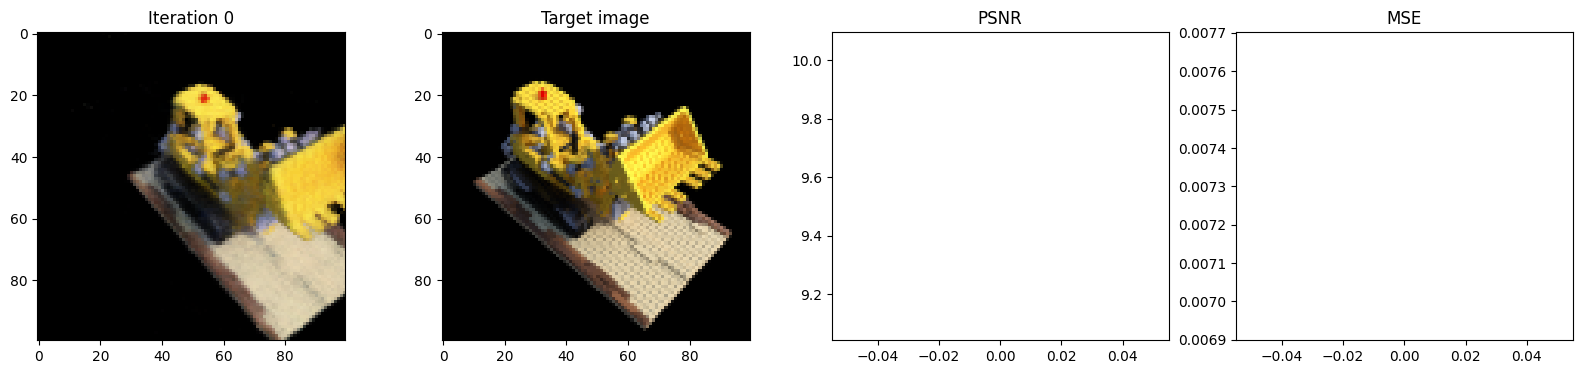

Test image MSE is: 0.0052681658416986465
Iteration 25  Loss: 0.0281  PSNR: 15.51  Time: 0.31 secs per iter,  7.69 mins in total


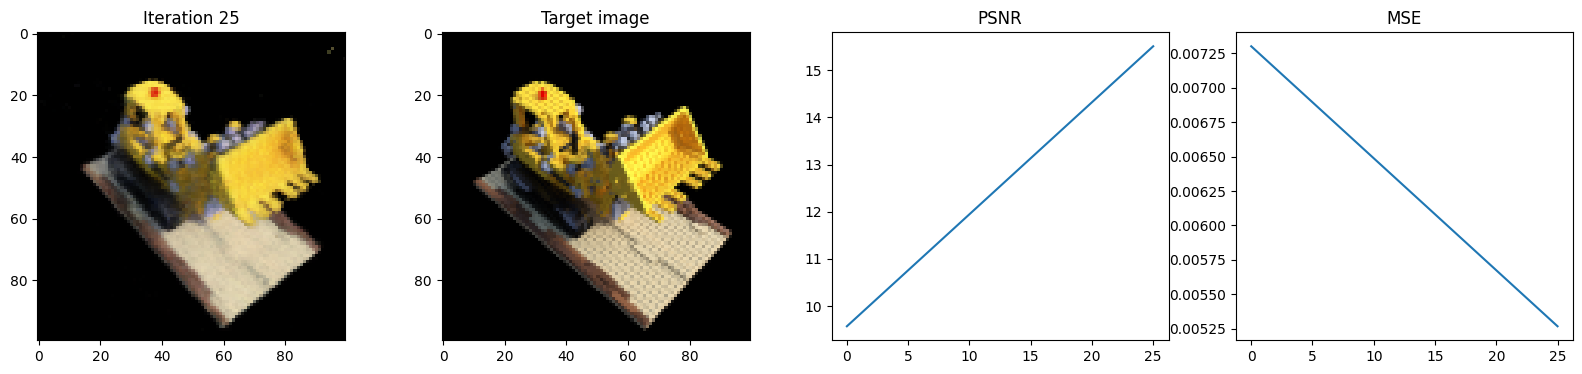

Test image MSE is: 0.004086656495928764
Iteration 50  Loss: 0.0214  PSNR: 16.71  Time: 0.31 secs per iter,  7.81 mins in total


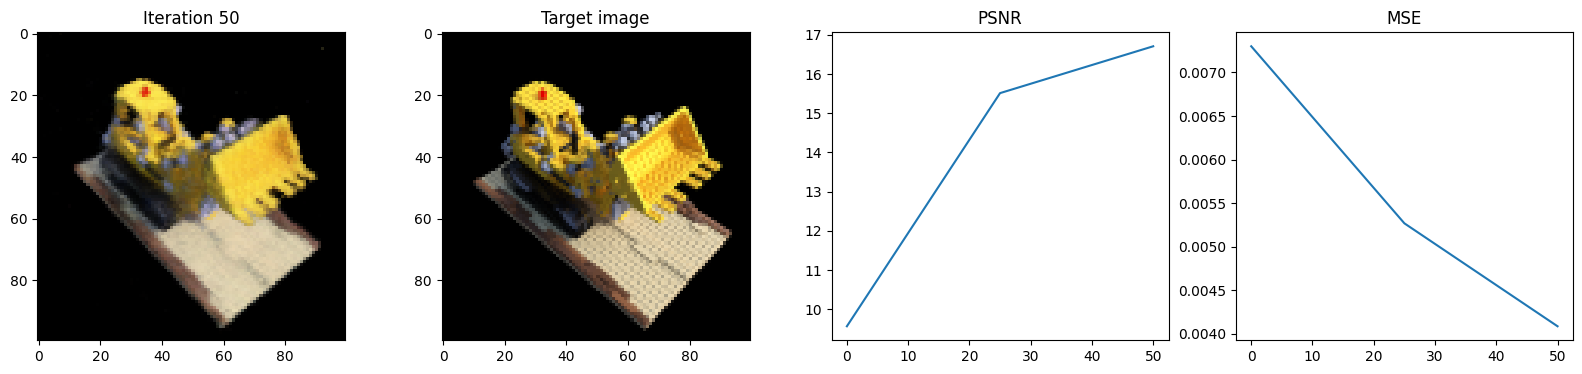

Test image MSE is: 0.003142158966511488
Iteration 75  Loss: 0.0154  PSNR: 18.14  Time: 0.31 secs per iter,  7.94 mins in total


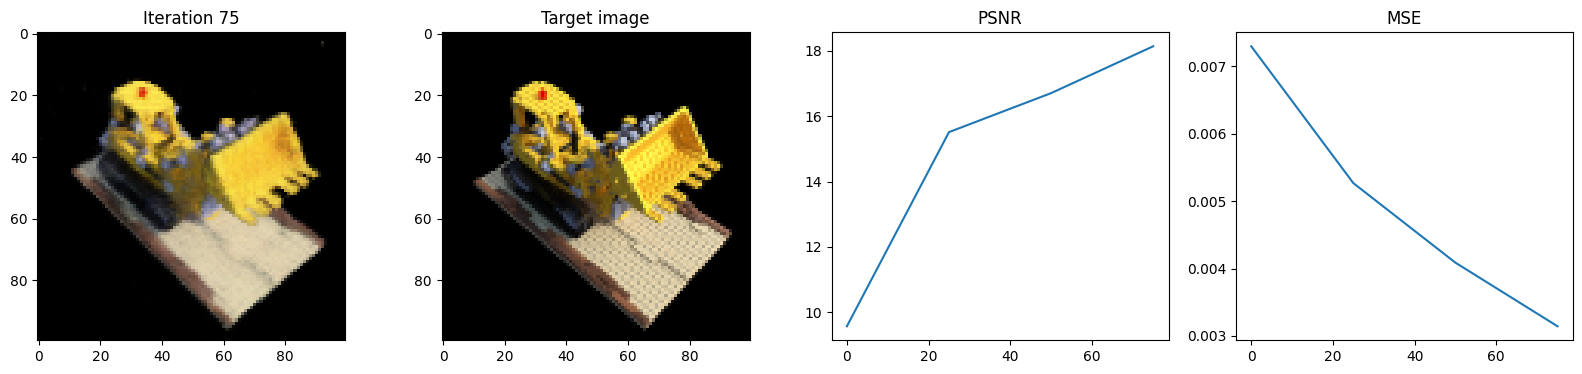

Test image MSE is: 0.002474803477525711
Iteration 100  Loss: 0.0105  PSNR: 19.78  Time: 0.30 secs per iter,  8.07 mins in total


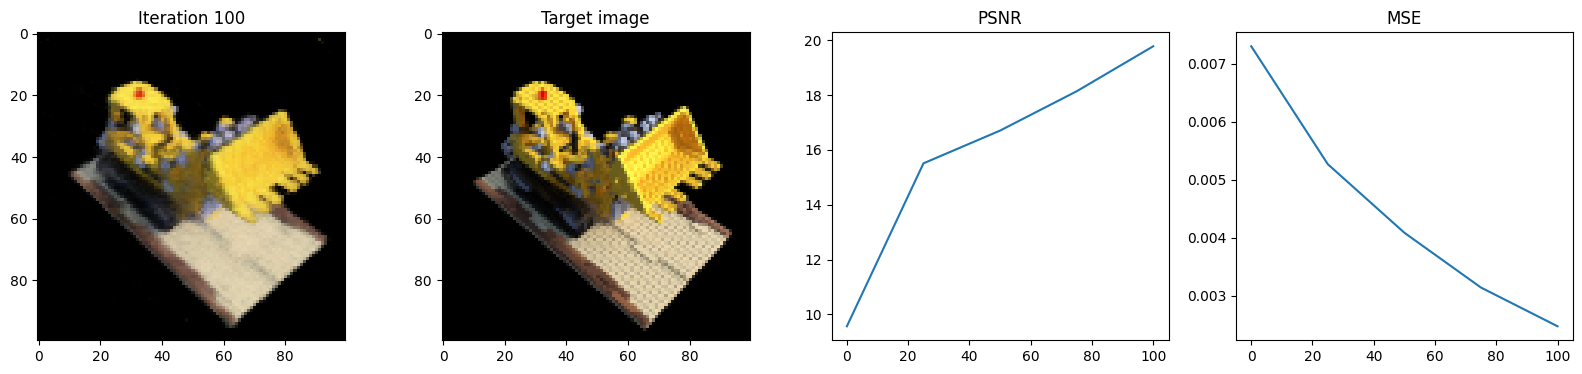

Test image MSE is: 0.0020431189332157373
Iteration 125  Loss: 0.0079  PSNR: 21.03  Time: 0.30 secs per iter,  8.19 mins in total


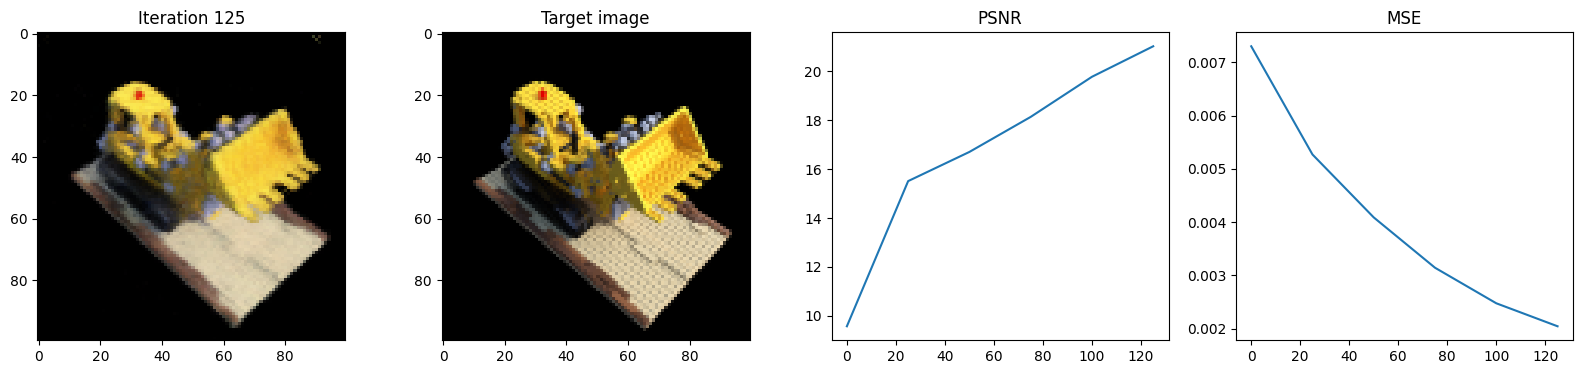

Test image MSE is: 0.0017337931785732508
Iteration 150  Loss: 0.0064  PSNR: 21.96  Time: 0.30 secs per iter,  8.32 mins in total


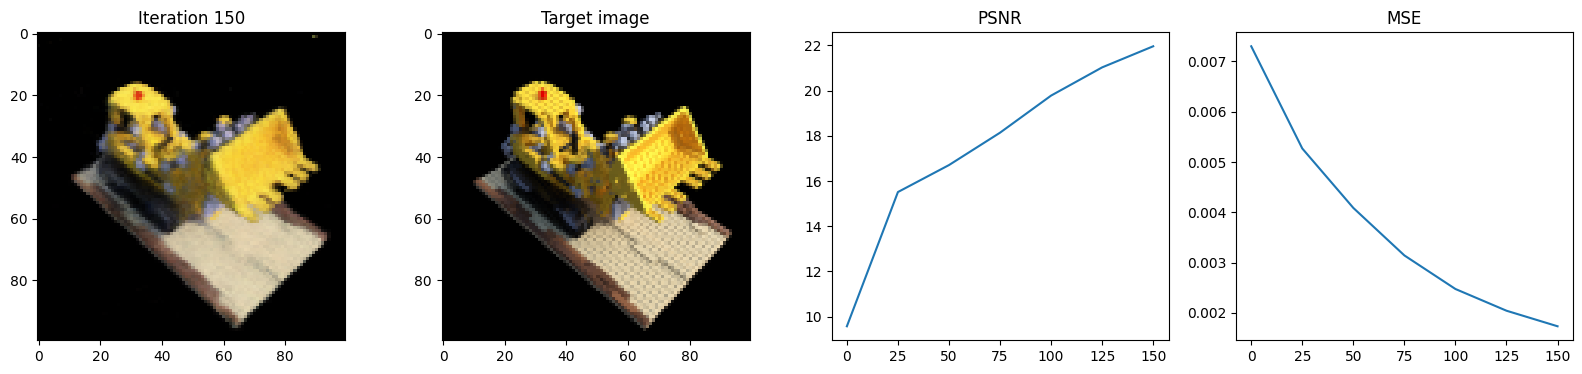

Test image MSE is: 0.0015280230436474085
Iteration 175  Loss: 0.0057  PSNR: 22.48  Time: 0.30 secs per iter,  8.45 mins in total


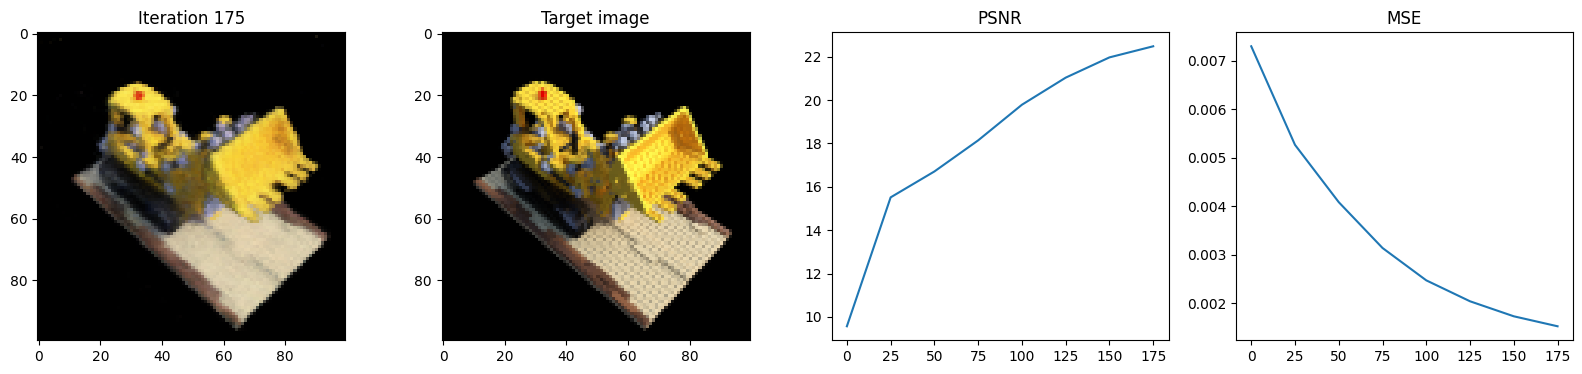

Test image MSE is: 0.0013601487735286355
Iteration 200  Loss: 0.0052  PSNR: 22.80  Time: 0.31 secs per iter,  8.58 mins in total


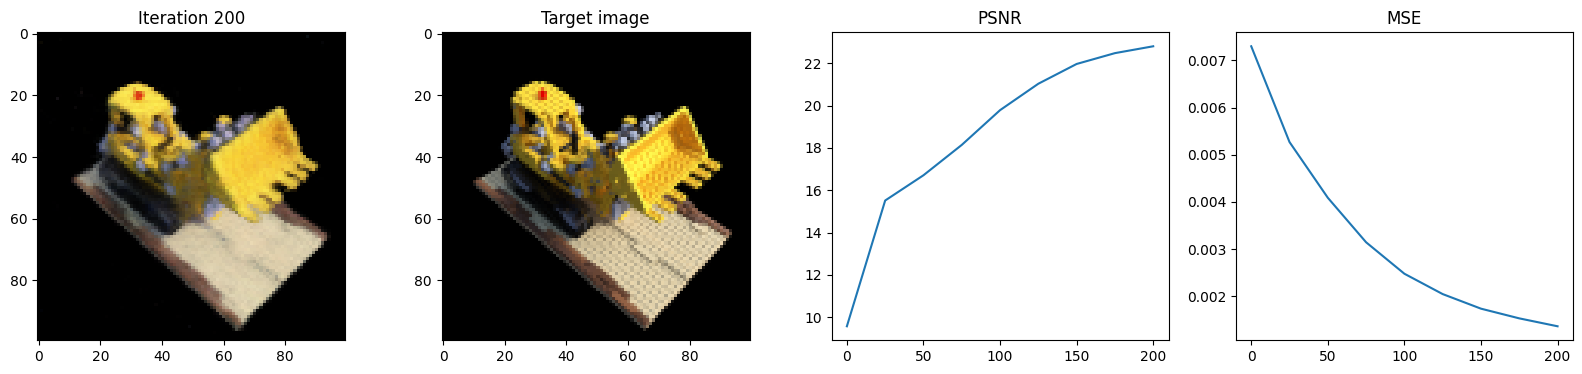

Test image MSE is: 0.0012202573707327247
Iteration 225  Loss: 0.0050  PSNR: 22.99  Time: 0.30 secs per iter,  8.70 mins in total


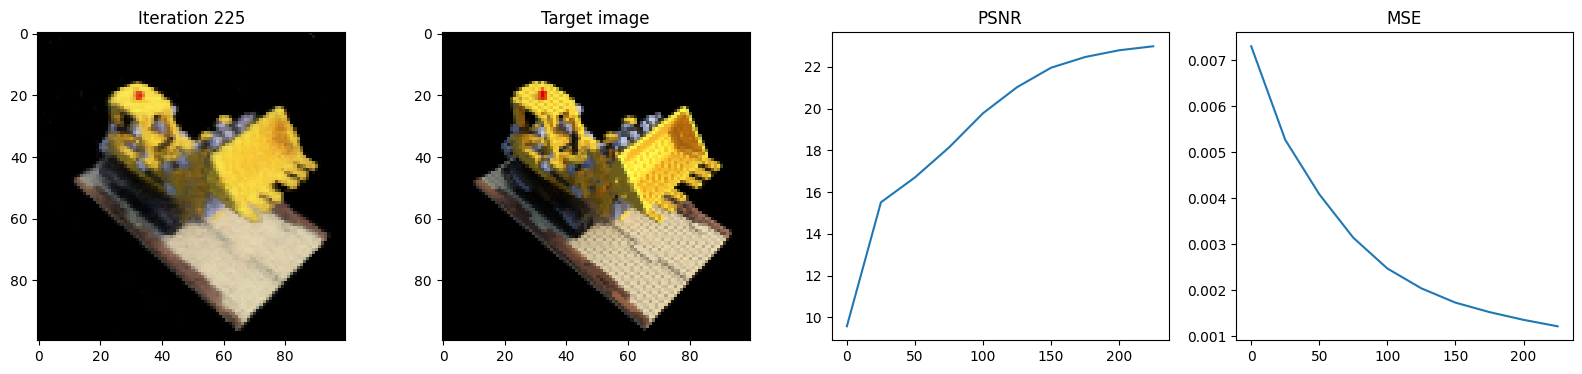

Test image MSE is: 0.0010896293679252267
Iteration 250  Loss: 0.0049  PSNR: 23.13  Time: 0.30 secs per iter,  8.83 mins in total


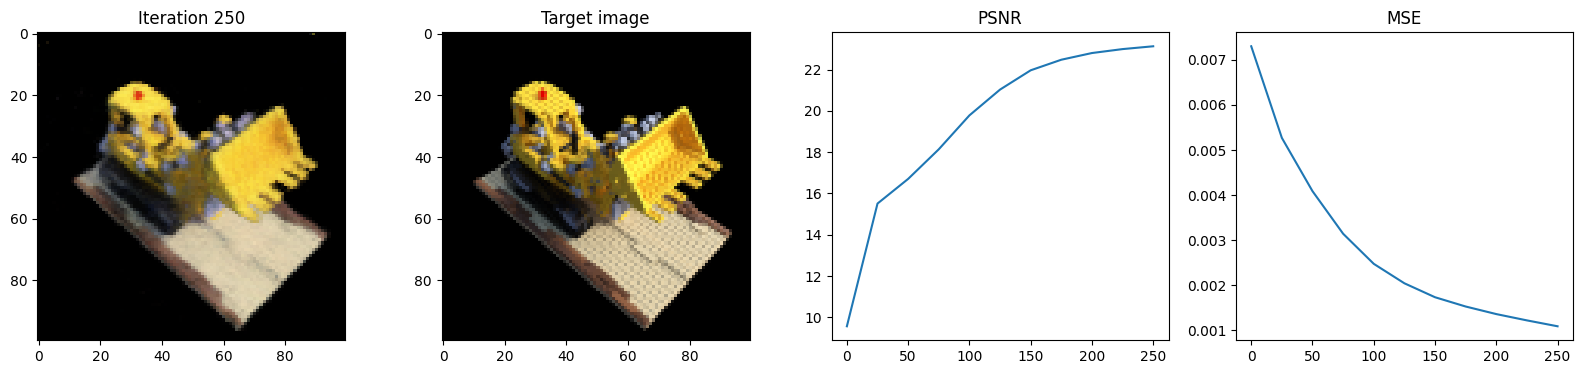

Test image MSE is: 0.0010885095689445734
Iteration 275  Loss: 0.0049  PSNR: 23.13  Time: 0.30 secs per iter,  8.96 mins in total


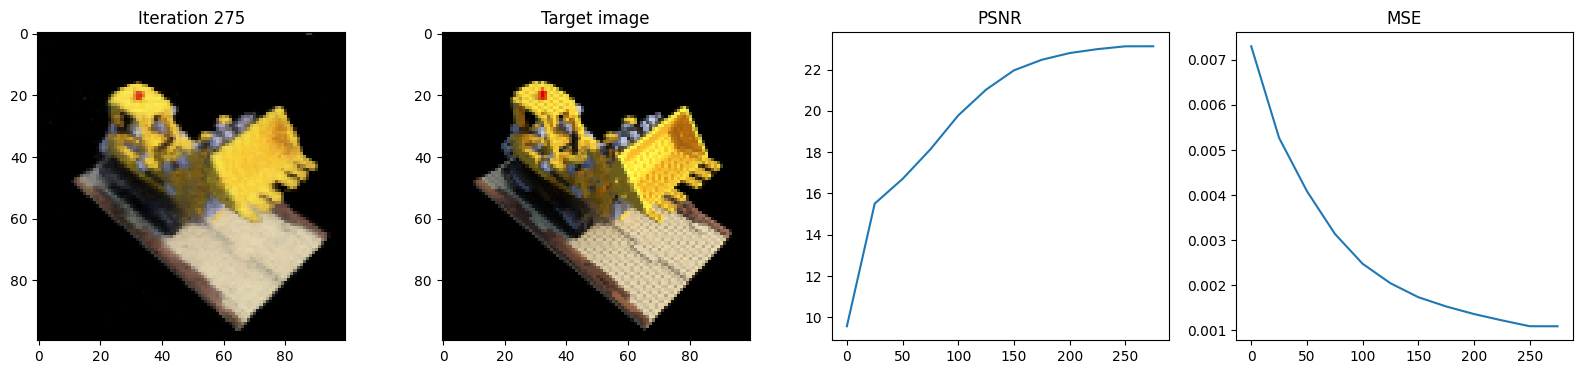

Test image MSE is: 0.0010873681167140603
Iteration 300  Loss: 0.0048  PSNR: 23.16  Time: 0.30 secs per iter,  9.08 mins in total


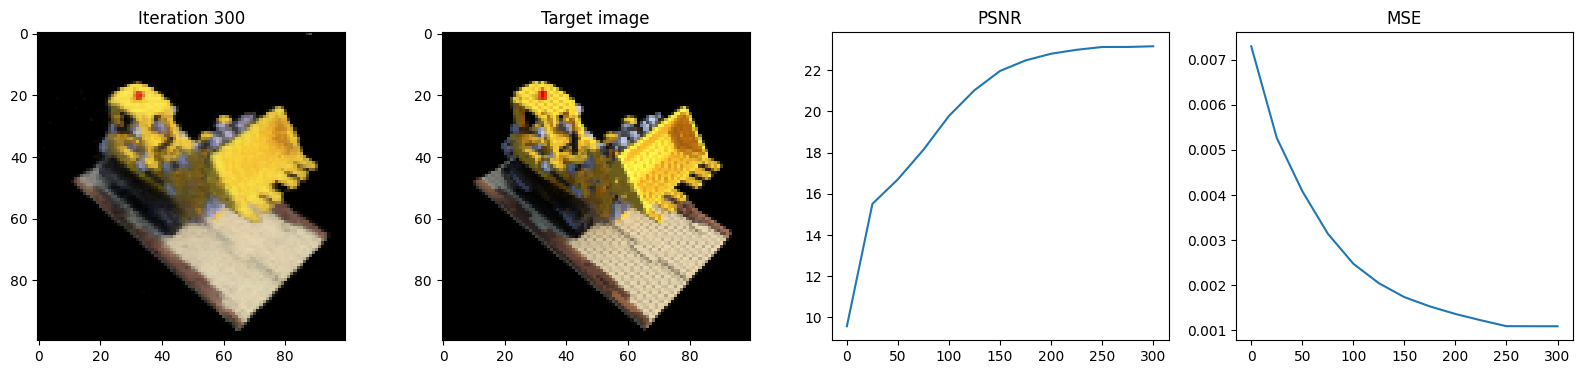

Test image MSE is: 0.001086259726434946
Iteration 325  Loss: 0.0048  PSNR: 23.19  Time: 0.30 secs per iter,  9.21 mins in total


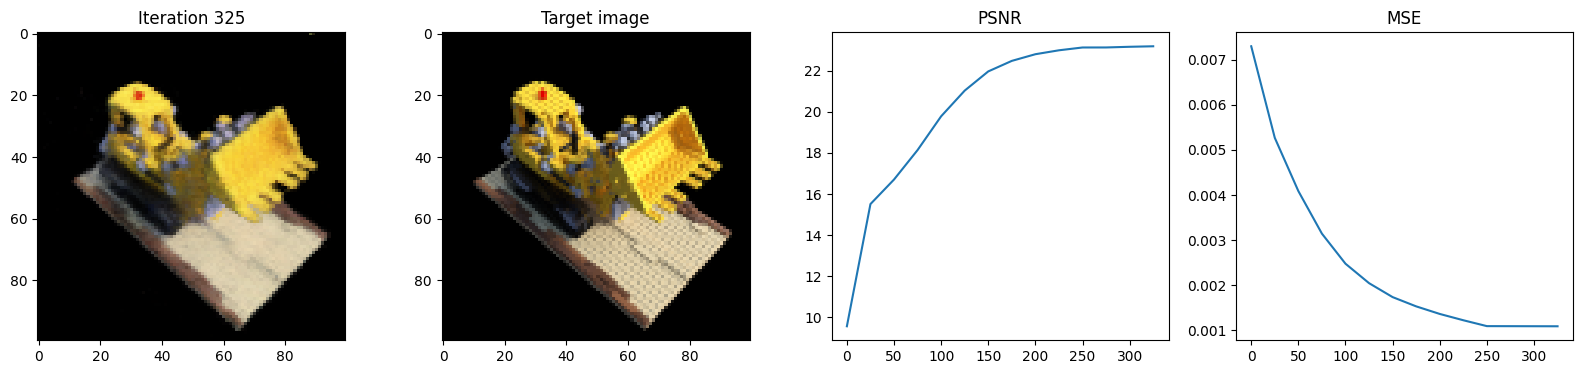

Test image MSE is: 0.0010851328261196613
Iteration 350  Loss: 0.0048  PSNR: 23.19  Time: 0.30 secs per iter,  9.34 mins in total


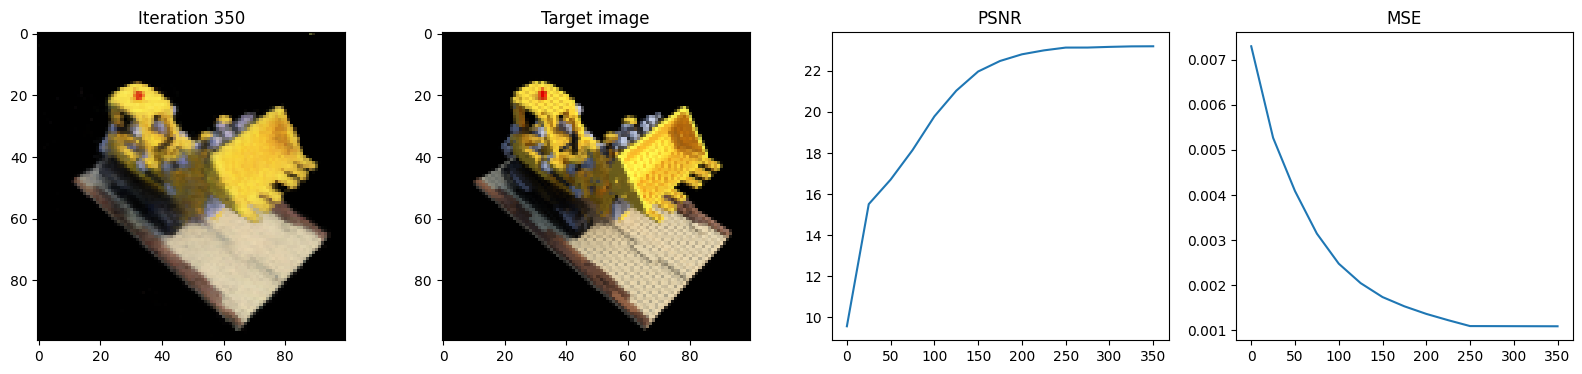

Test image MSE is: 0.0010839480673894286
Iteration 375  Loss: 0.0048  PSNR: 23.19  Time: 0.30 secs per iter,  9.46 mins in total


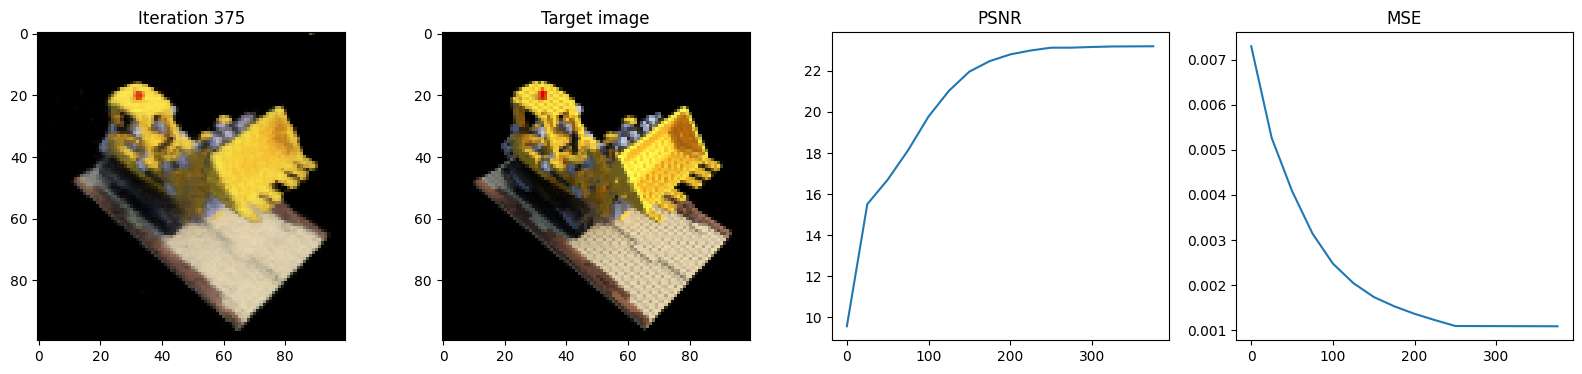

Test image MSE is: 0.0010827166261151433
Iteration 400  Loss: 0.0048  PSNR: 23.20  Time: 0.30 secs per iter,  9.59 mins in total


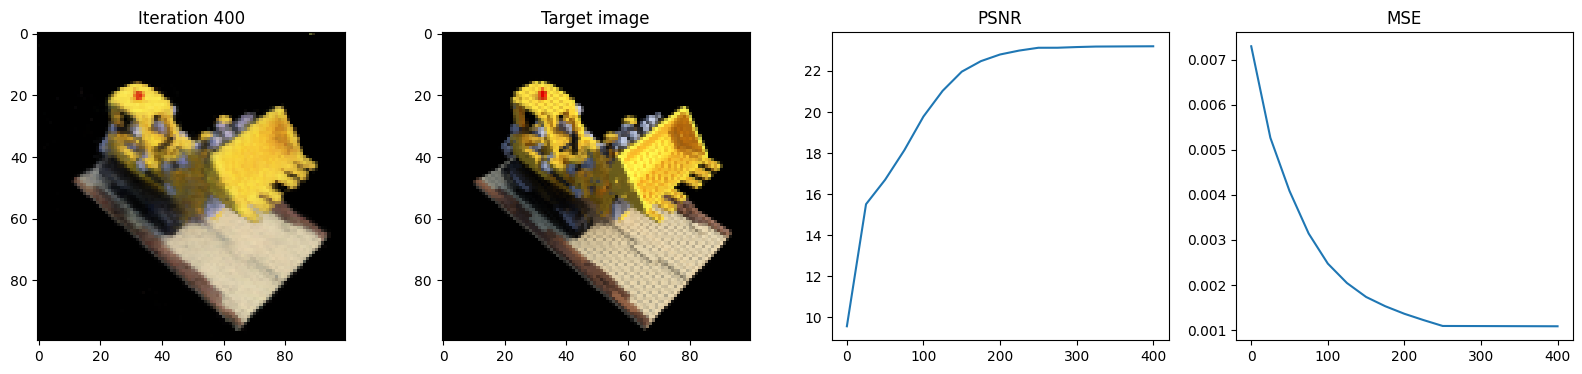

Test image MSE is: 0.0010814934503287077
Iteration 425  Loss: 0.0048  PSNR: 23.20  Time: 0.30 secs per iter,  9.72 mins in total


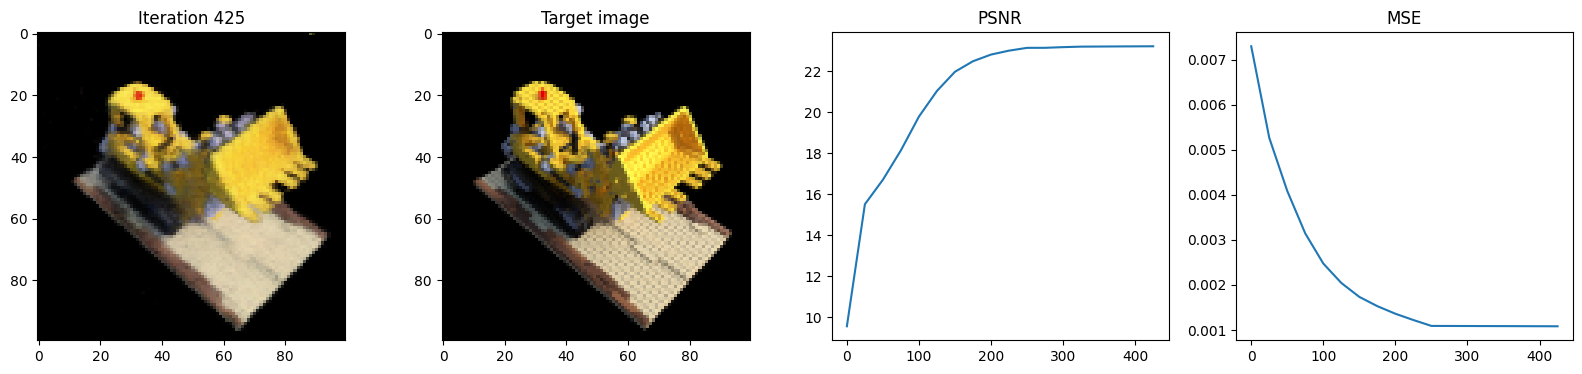

Test image MSE is: 0.0010802852921187878
Iteration 450  Loss: 0.0048  PSNR: 23.21  Time: 0.30 secs per iter,  9.84 mins in total


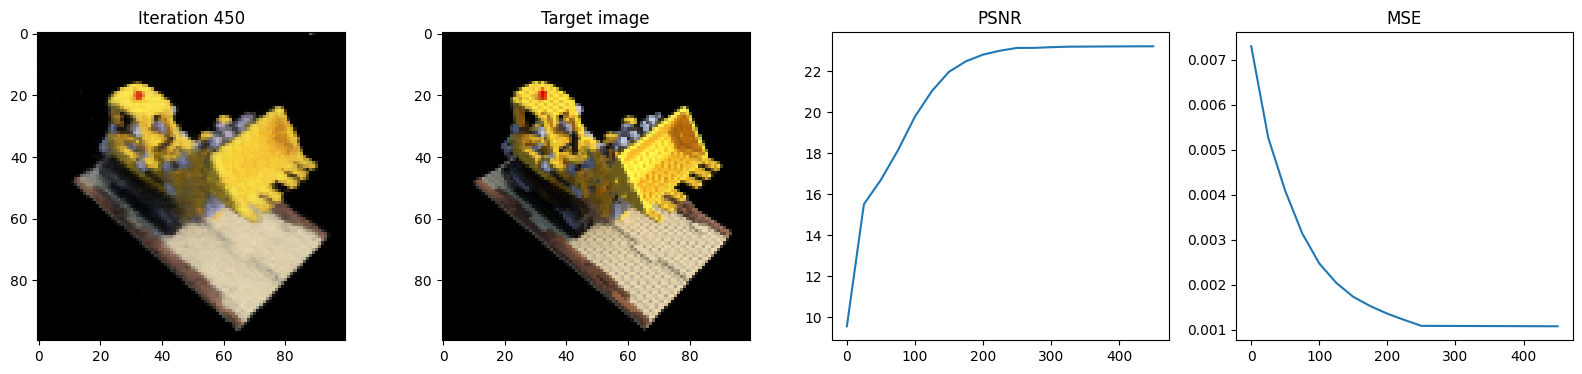

Test image MSE is: 0.0010790956439450383
Iteration 475  Loss: 0.0048  PSNR: 23.21  Time: 0.30 secs per iter,  9.97 mins in total


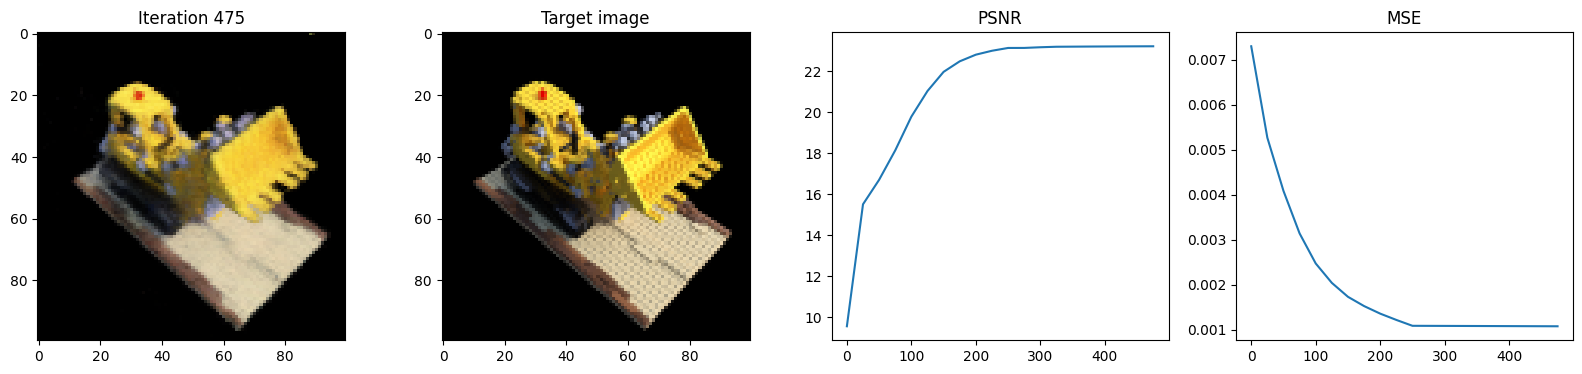

In [39]:
### iterating to see how the error reduces on rotation
mse_list = []
iternums = []
psnrs = []
for i in range(500):
    test_input = copy.deepcopy(test_pose_w_R_c_perturb)
    test_input.requires_grad_()
    # Run one iteration of NeRF and get the rendered RGB image.

    rec_image = one_forward_pass(height, width, intrinsics, test_input.to(device), test_pose_w_T_c.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_R_c_perturb = test_pose_w_R_c_perturb - lr_rotation * test_input.grad.detach()
     
    mse = criterion(test_pose_w_R_c_perturb.to('cpu'),test_pose_w_R_c.to('cpu')).detach().item()
    if i%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(mse)

        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
    
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)
    
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, mse_list)
        plt.title("MSE")
        plt.show()
    if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.01

    

### Translation only

In [47]:
### test image
test_pose_w_R_c = test_pose[:3,:3]
test_pose_w_T_c = test_pose[:3, 3]
pose_noise = 0.2 # radians
noise = torch.randn_like(test_pose_w_T_c)
test_pose_w_T_c_perturb = test_pose_w_T_c + pose_noise * noise

In [48]:
lr_rotation = 0.01

Test image MSE is: 0.026209505274891853
Iteration 0  Loss: 0.1495  PSNR: 8.25  Time: 0.63 secs per iter,  12.64 mins in total


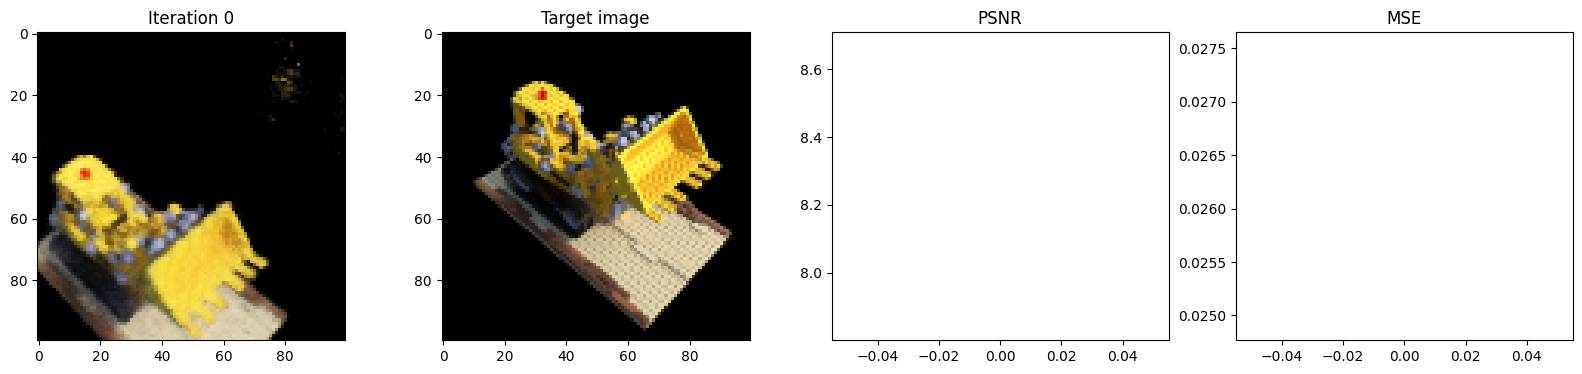

Test image MSE is: 0.02037830837070942
Iteration 25  Loss: 0.1200  PSNR: 9.21  Time: 0.29 secs per iter,  12.76 mins in total


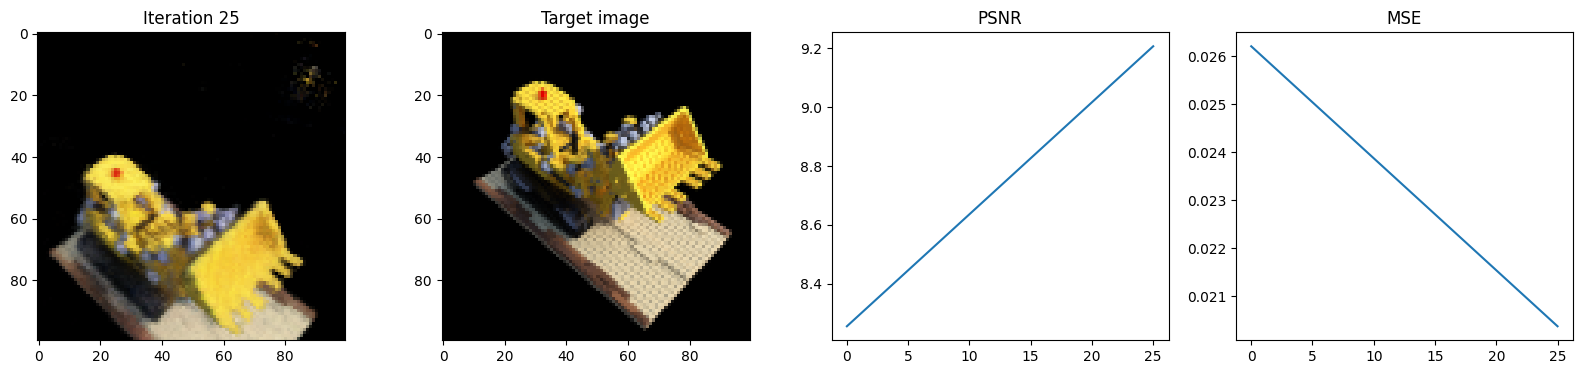

Test image MSE is: 0.018585851415991783
Iteration 50  Loss: 0.1177  PSNR: 9.29  Time: 0.29 secs per iter,  12.88 mins in total


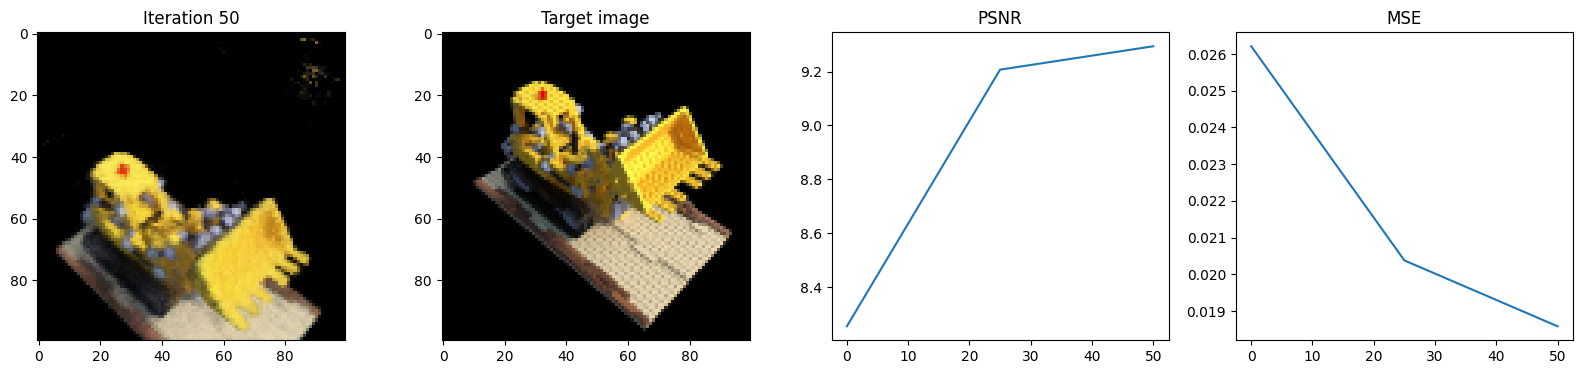

Test image MSE is: 0.015249124728143215
Iteration 75  Loss: 0.1132  PSNR: 9.46  Time: 0.29 secs per iter,  13.00 mins in total


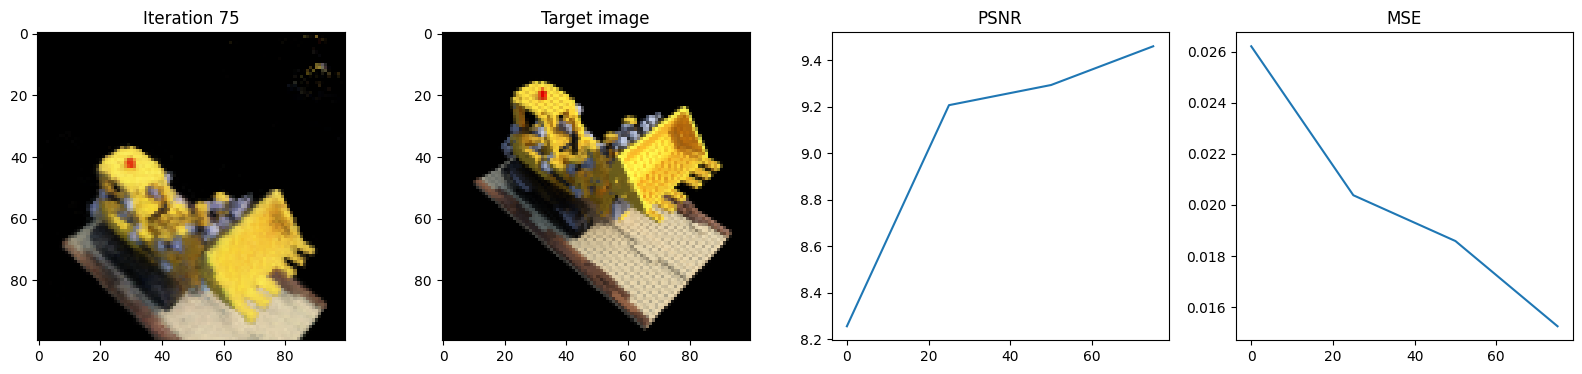

Test image MSE is: 0.00969715602695942
Iteration 100  Loss: 0.1037  PSNR: 9.84  Time: 0.29 secs per iter,  13.12 mins in total


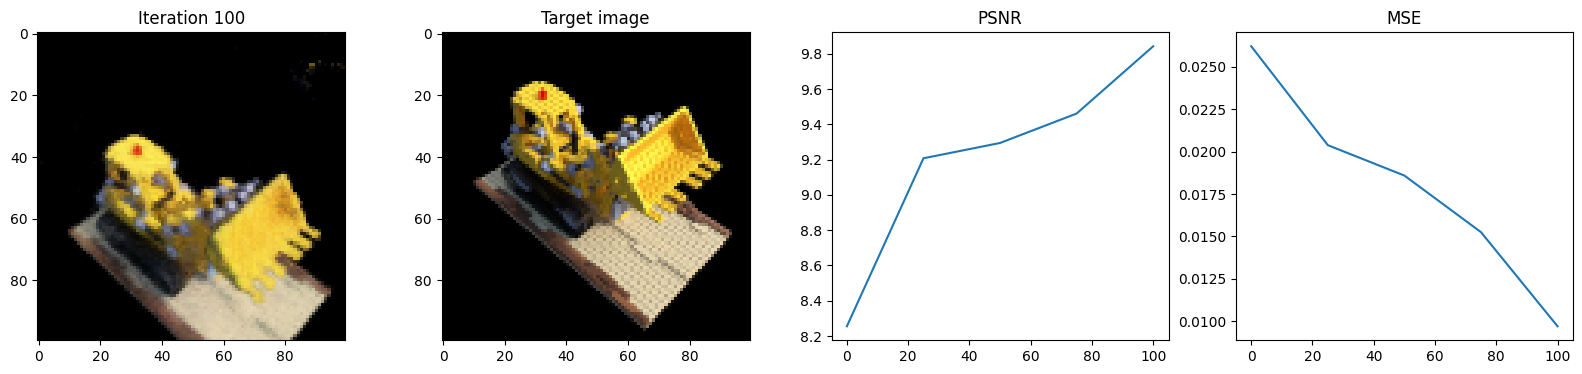

Test image MSE is: 0.0032892003655433655
Iteration 125  Loss: 0.0828  PSNR: 10.82  Time: 0.29 secs per iter,  13.25 mins in total


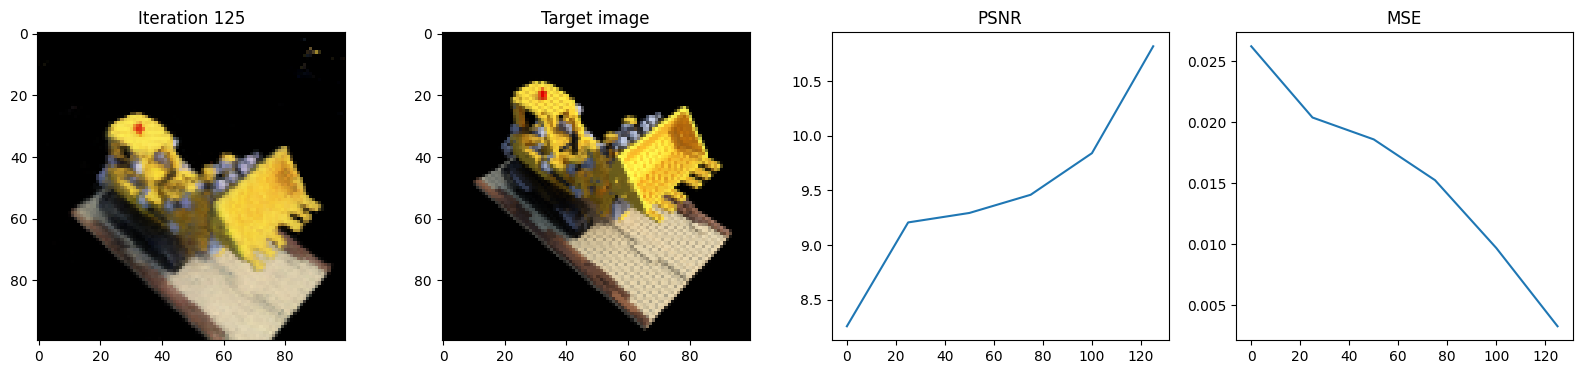

Test image MSE is: 5.3821445362700615e-06
Iteration 150  Loss: 0.0035  PSNR: 24.59  Time: 0.29 secs per iter,  13.37 mins in total


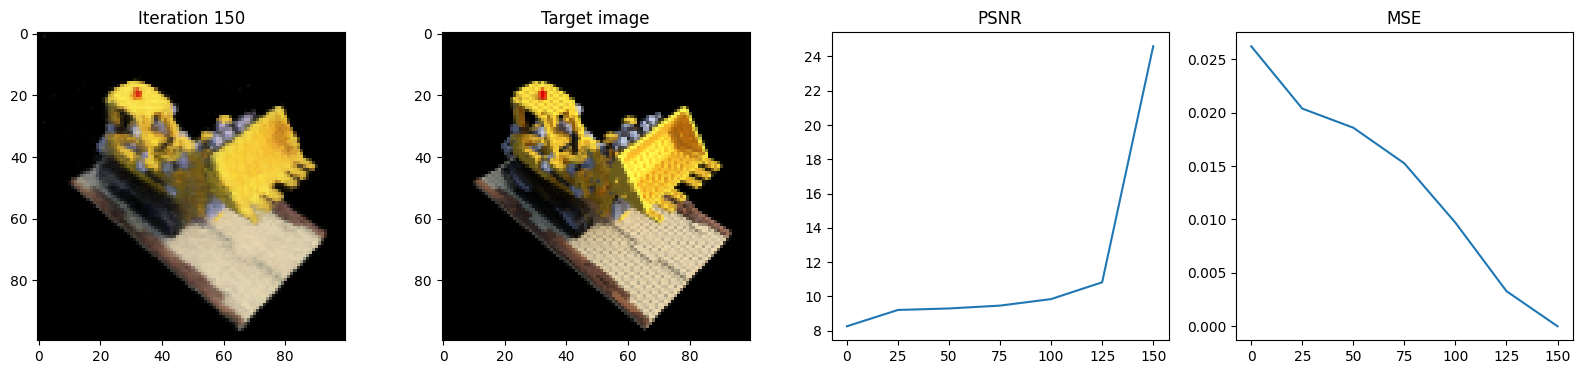

Test image MSE is: 2.6784055080497637e-06
Iteration 175  Loss: 0.0034  PSNR: 24.70  Time: 0.29 secs per iter,  13.49 mins in total


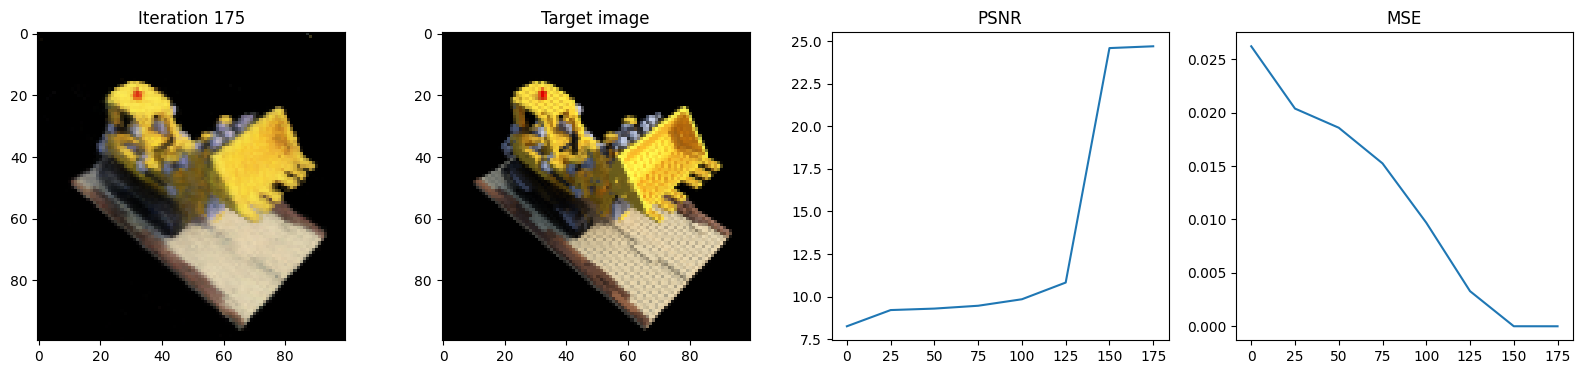

Test image MSE is: 1.918658426802722e-06
Iteration 200  Loss: 0.0034  PSNR: 24.69  Time: 0.30 secs per iter,  13.61 mins in total


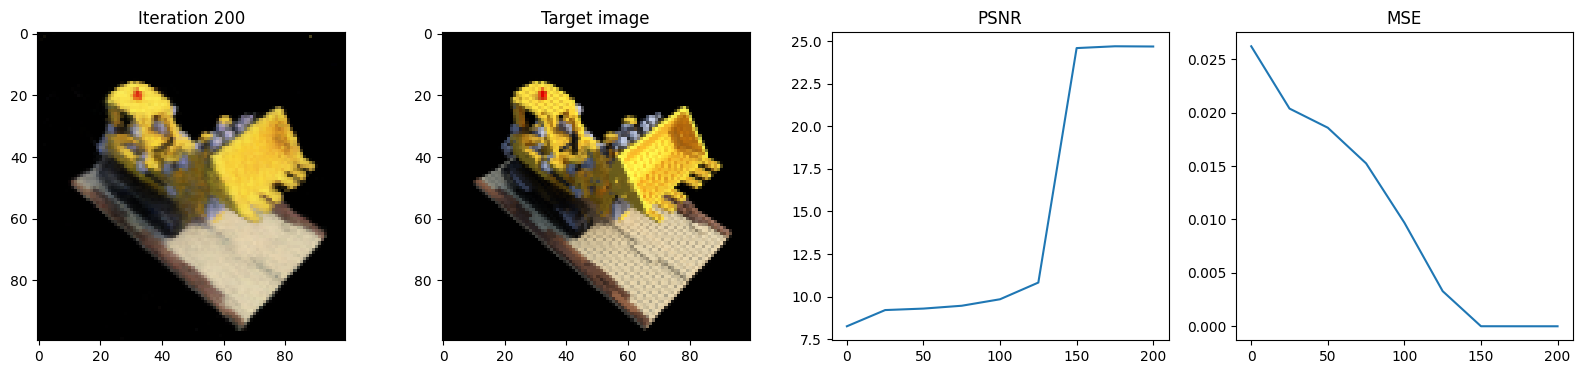

Test image MSE is: 3.1689050956629217e-06
Iteration 225  Loss: 0.0034  PSNR: 24.64  Time: 0.29 secs per iter,  13.73 mins in total


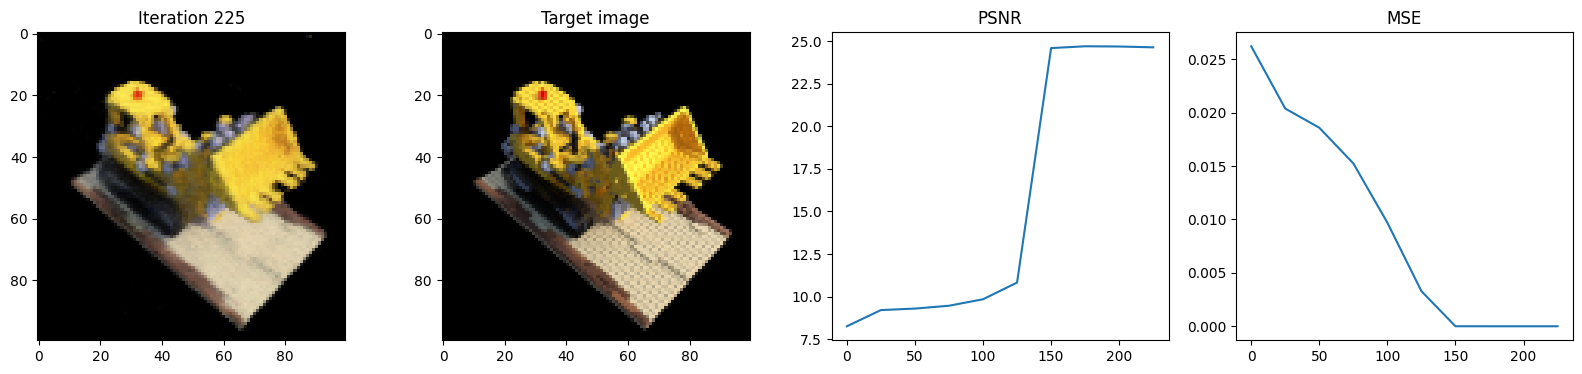

Test image MSE is: 3.1674464935349533e-06
Iteration 250  Loss: 0.0034  PSNR: 24.68  Time: 0.29 secs per iter,  13.86 mins in total


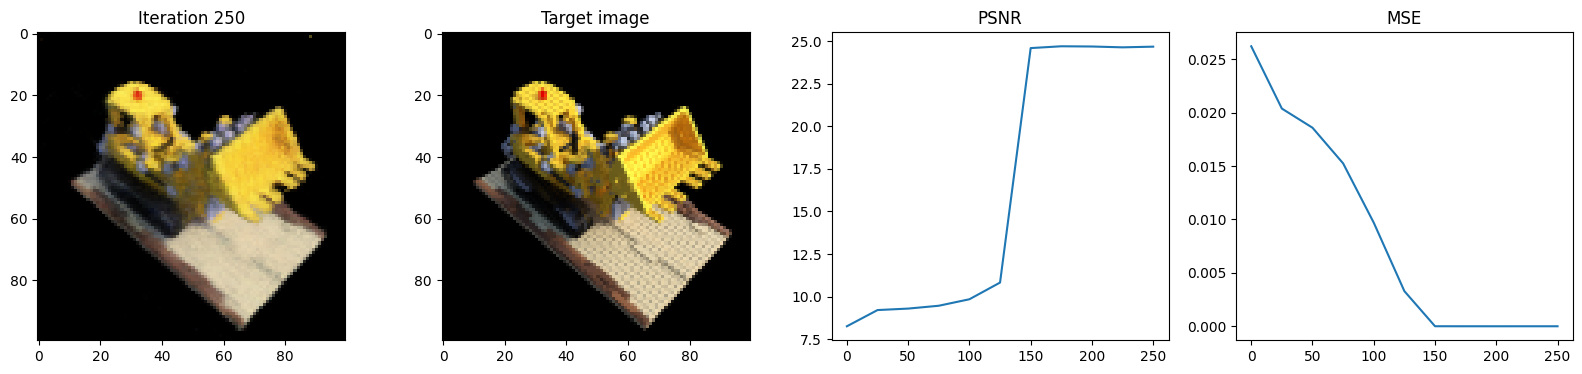

Test image MSE is: 2.773082997009624e-06
Iteration 275  Loss: 0.0034  PSNR: 24.69  Time: 0.29 secs per iter,  13.98 mins in total


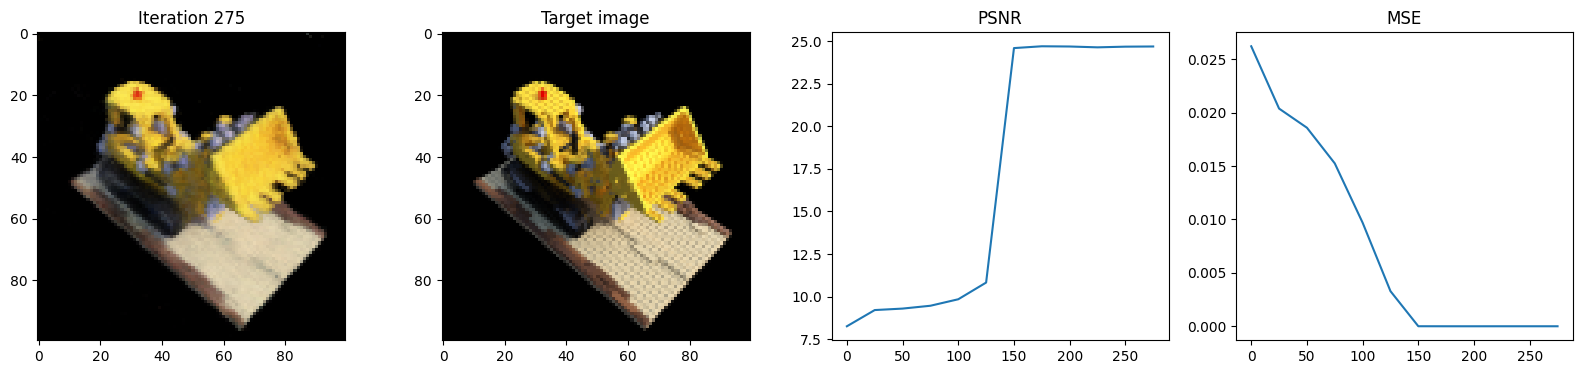

Test image MSE is: 2.5819899747148156e-06
Iteration 300  Loss: 0.0034  PSNR: 24.73  Time: 0.29 secs per iter,  14.10 mins in total


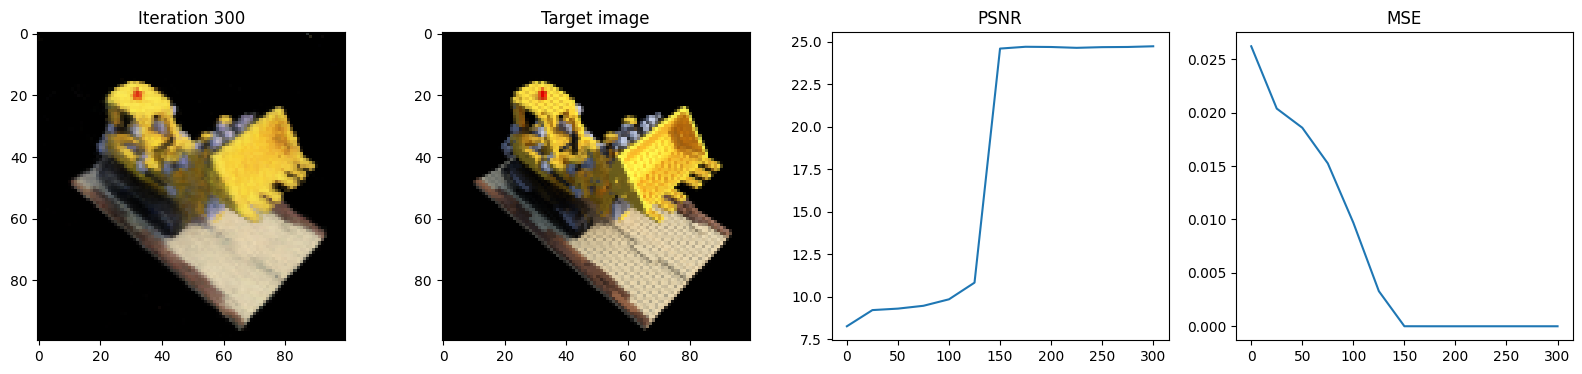

Test image MSE is: 2.4596929506515153e-06
Iteration 325  Loss: 0.0034  PSNR: 24.75  Time: 0.29 secs per iter,  14.22 mins in total


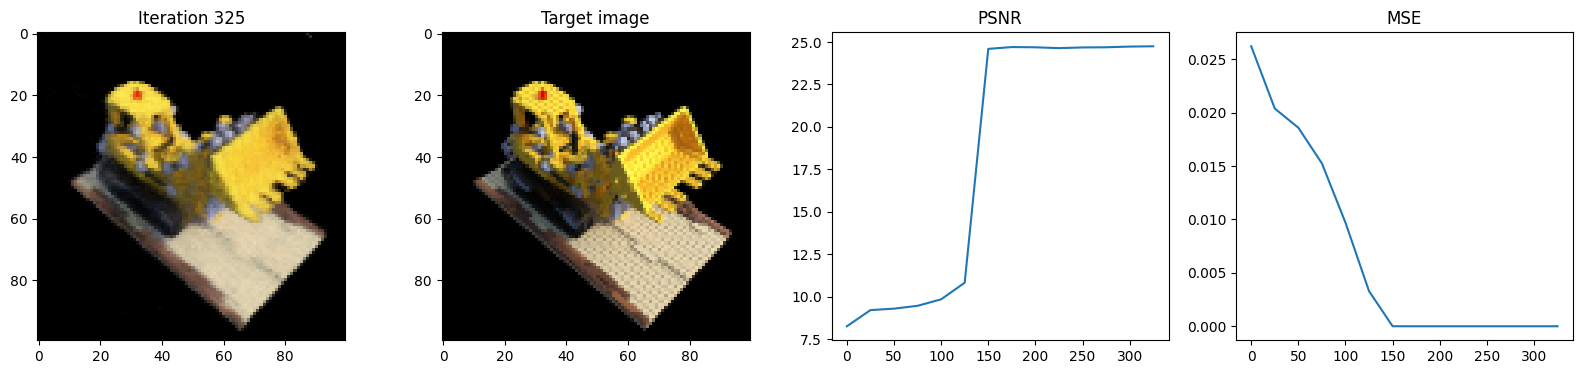

Test image MSE is: 2.406799467280507e-06
Iteration 350  Loss: 0.0033  PSNR: 24.75  Time: 0.29 secs per iter,  14.34 mins in total


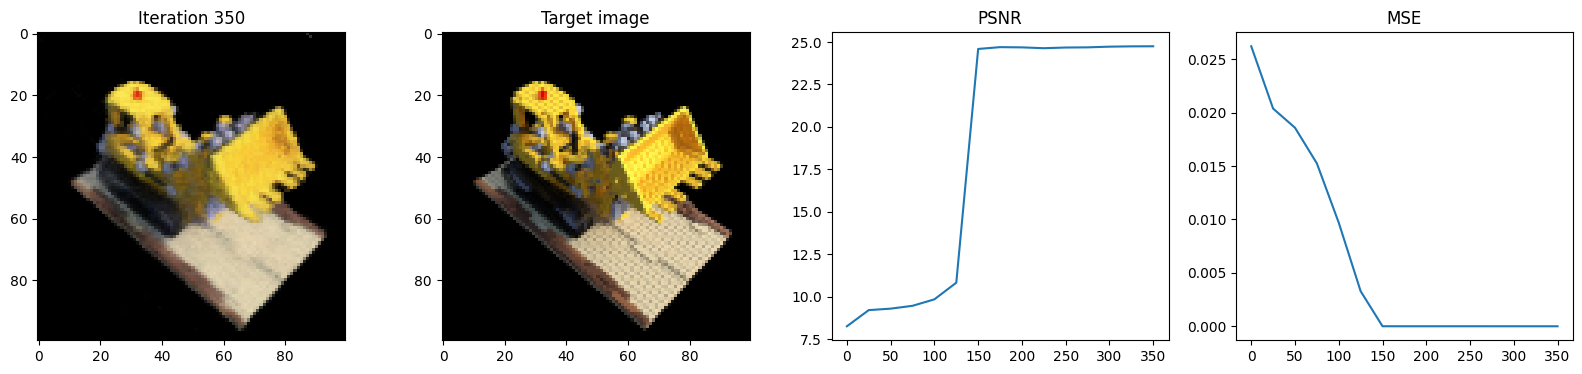

Test image MSE is: 2.358013489356381e-06
Iteration 375  Loss: 0.0033  PSNR: 24.76  Time: 0.29 secs per iter,  14.46 mins in total


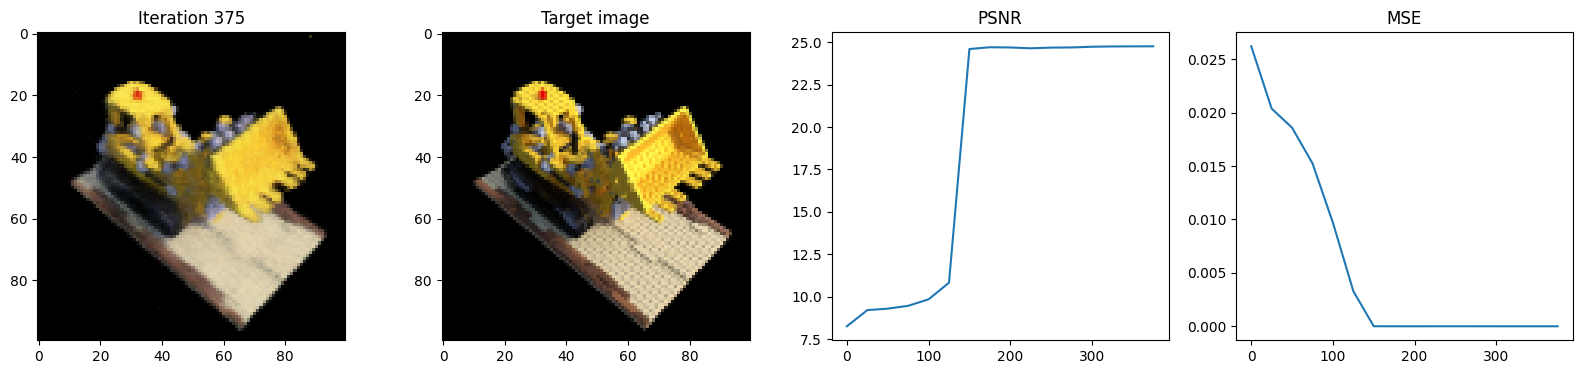

Test image MSE is: 2.3227544261317234e-06
Iteration 400  Loss: 0.0033  PSNR: 24.76  Time: 0.29 secs per iter,  14.59 mins in total


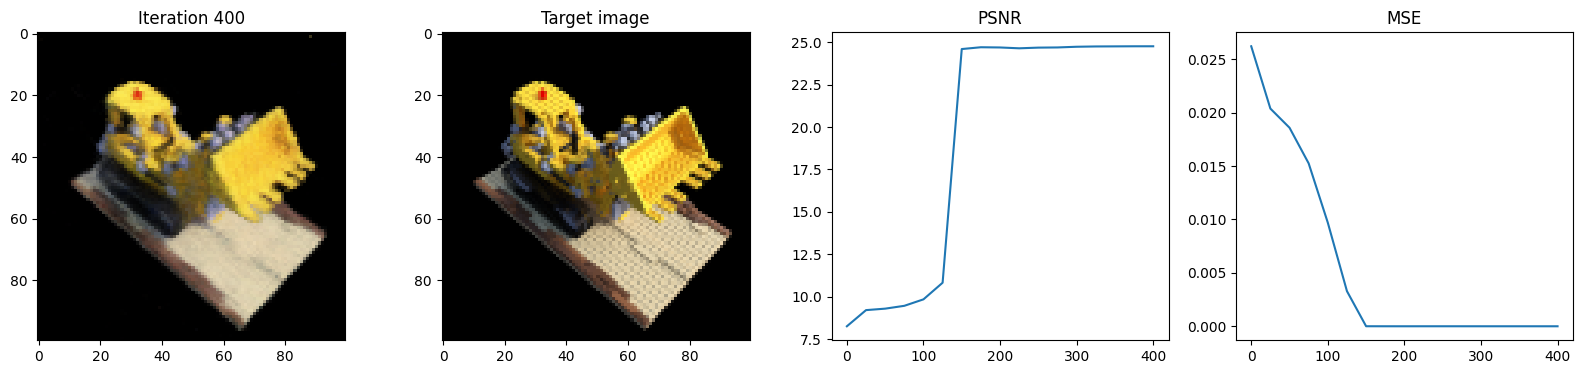

Test image MSE is: 2.31379840442969e-06
Iteration 425  Loss: 0.0033  PSNR: 24.76  Time: 0.29 secs per iter,  14.71 mins in total


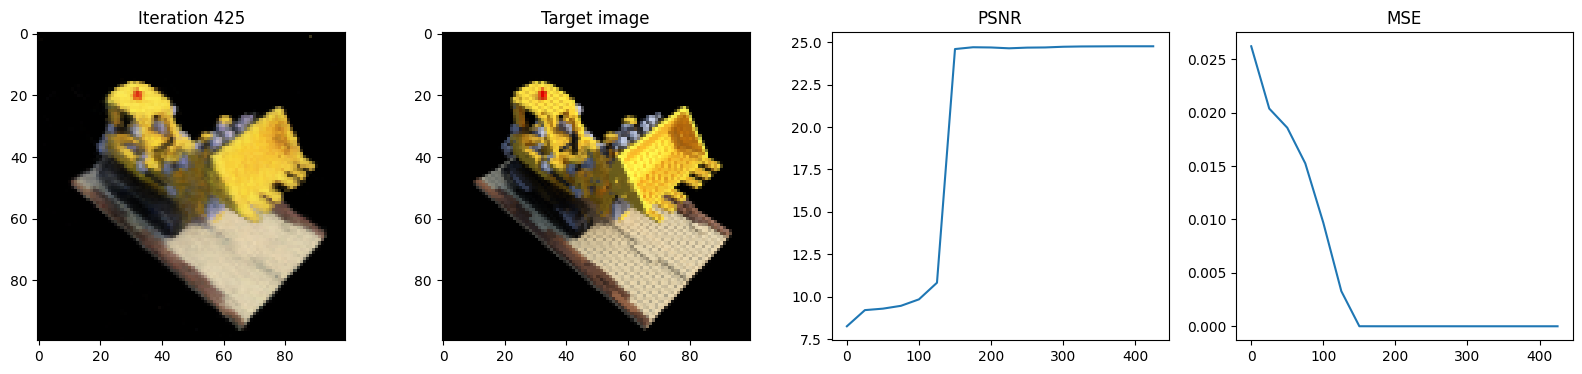

Test image MSE is: 2.31379840442969e-06
Iteration 450  Loss: 0.0033  PSNR: 24.76  Time: 0.30 secs per iter,  14.83 mins in total


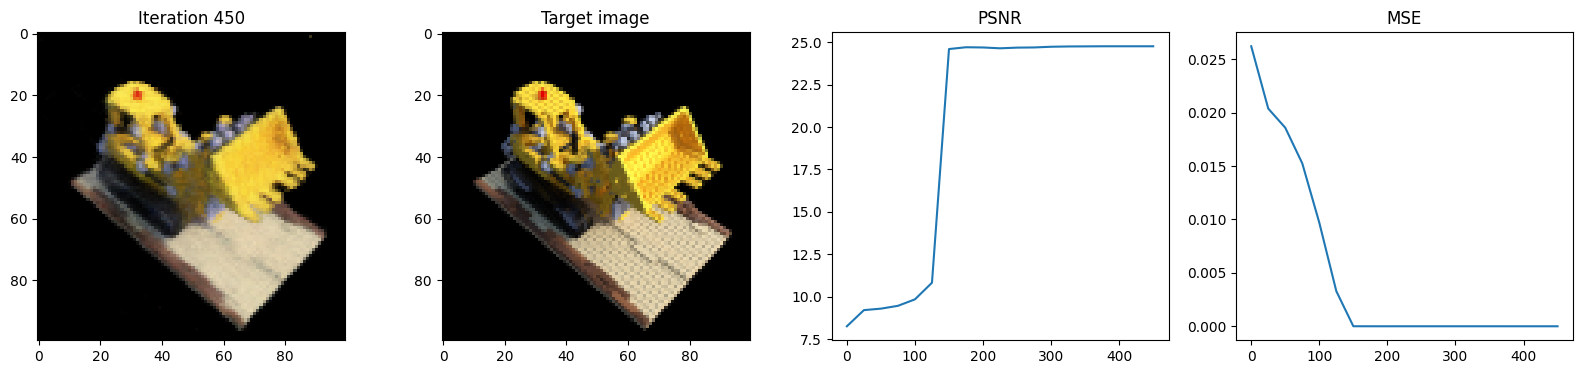

Test image MSE is: 2.31379840442969e-06
Iteration 475  Loss: 0.0033  PSNR: 24.76  Time: 0.29 secs per iter,  14.95 mins in total


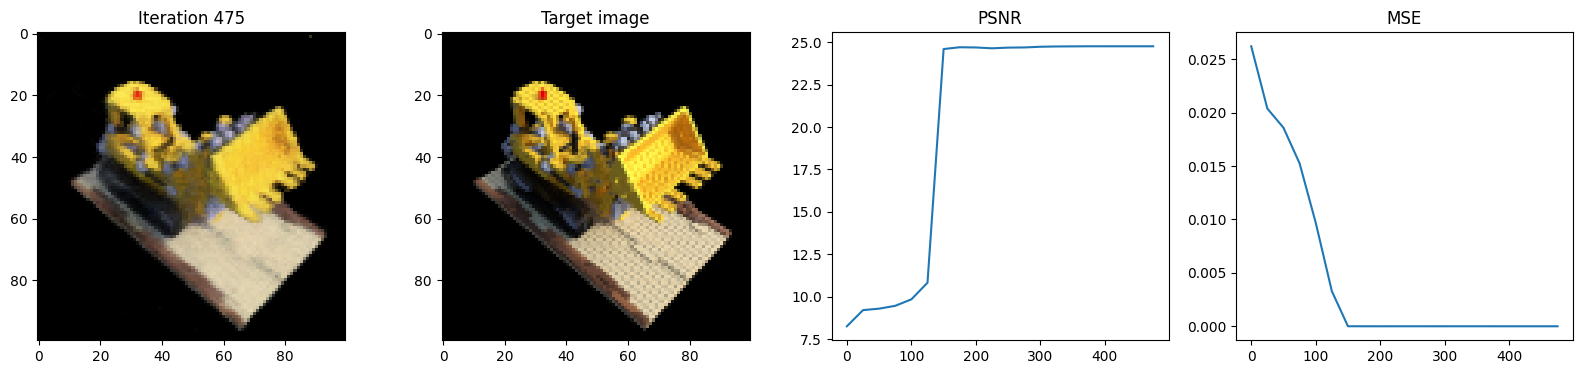

In [49]:
### iterating to see how the error reduces on rotation
mse_list = []
iternums = []
psnrs = []
for i in range(500):
    test_input = copy.deepcopy(test_pose_w_T_c_perturb)
    test_input.requires_grad_()
    # Run one iteration of NeRF and get the rendered RGB image.

    rec_image = one_forward_pass(height, width, intrinsics, test_pose_w_R_c.to(device), test_input.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_T_c_perturb = test_pose_w_T_c_perturb - lr_rotation * test_input.grad.detach()
     
    mse = criterion(test_pose_w_T_c_perturb.to('cpu'),test_pose_w_T_c.to('cpu')).detach().item()
    if i%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(mse)

        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
    
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, mse_list)
        plt.title("MSE")
        plt.show()
    if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.01